<a href="https://colab.research.google.com/github/Danysan1/ai-unibo-nlp-project/blob/main/execution_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assigment 1 execution

Corpora: https://www.nltk.org/nltk_data/ , point 91, "Dependency Parsed Treebank" ([link](https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip)).

Docs:
* https://www.nltk.org/api/nltk.corpus.html
* https://www.nltk.org/data.html
* https://www.nltk.org/install.html

## Preparing the environment

In [101]:
%pip install pandas numpy matplotlib gensim

/bin/bash: /home/daniele/.miniconda3/envs/tf/lib/libtinfo.so.6: no version information available (required by /bin/bash)
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 24.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.6/58.6 kB 249.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [80]:
import os, shutil  #  file management
import sys 
import pandas as pd  #  dataframe management
import numpy as np  #  data manipulation
import re
import urllib.request  # download files
from zipfile import ZipFile # extract files
from matplotlib import pyplot as plt

## Downloading the dataset

In [81]:
#from nltk import download
#download()

In [82]:
dataset_folder = os.path.join(os.getcwd(), "Dataset")

if not os.path.exists(dataset_folder):
    os.makedirs(dataset_folder)

url = 'https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/packages/corpora/dependency_treebank.zip'

dataset_path = os.path.join(dataset_folder, "dependency_treebank.zip")

if not os.path.exists(dataset_path):
    urllib.request.urlretrieve(url, dataset_path)
    print("Successful download")
    
with ZipFile(dataset_path, 'r') as zObject:
  # Extracting all the members of the zip  into a specific location.
  zObject.extractall(dataset_folder)
  print("Successful extraction")

Successful extraction


## Loading the data

In [83]:
#from nltk.corpus import dependency_treebank
#from nltk.data import load
#dependency_treebank_test = load("nltk:") 
#sentences = dependency_treebank.sents()
#words = dependency_treebank.words()

In [84]:
def loadCorpus(start, stop=None):
    '''
    Loads the data for the specified file range.
    
    Removes the third column 'num', which is not necessary for this task.

    Parameters:
        start: start of numeric range of files (inclusive)
        stop: end of numeric range of files (exclusive)
    '''
    dataset_name = "dependency_treebank"
    folder = os.path.join(os.getcwd(), "Dataset", dataset_name)

    if stop==None:
        stop = start+1
    
    return pd.concat([
        pd.read_csv(
            f'{folder}/wsj_{"{:04d}".format(num)}.dp',
            sep="\t",
            usecols=[0,1],
            names=["word","label"]
        ) for num in range(start, stop)
    ])

In [85]:
full_dataset = loadCorpus(1,200)

## Exploratory Data Analysis

In [86]:
full_dataset.count()

word     94084
label    94084
dtype: int64

In [87]:
full_dataset.head(10)

,word,label
0,Pierre,NNP
1,Vinken,NNP
2,",",","
3,61,CD
4,years,NNS
5,old,JJ
6,",",","
7,will,MD
8,join,VB
9,the,DT


Each document contains a different tokenized article:

In [88]:
" ".join(loadCorpus(1)["word"])

'Pierre Vinken , 61 years old , will join the board as a nonexecutive director Nov. 29 . Mr. Vinken is chairman of Elsevier N.V. , the Dutch publishing group .'

In [89]:
" ".join(loadCorpus(2)["word"])

'Rudolph Agnew , 55 years old and former chairman of Consolidated Gold Fields PLC , was named a nonexecutive director of this British industrial conglomerate .'

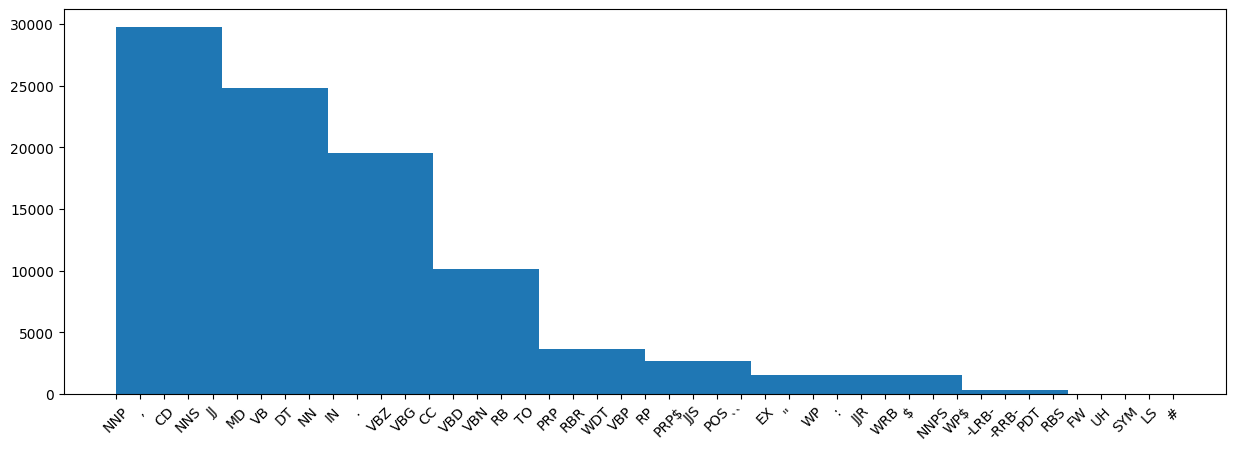

In [90]:
fig=plt.figure(figsize=(15,5))
p = plt.hist(full_dataset["label"])
plt.xticks(rotation=45)
plt.show()

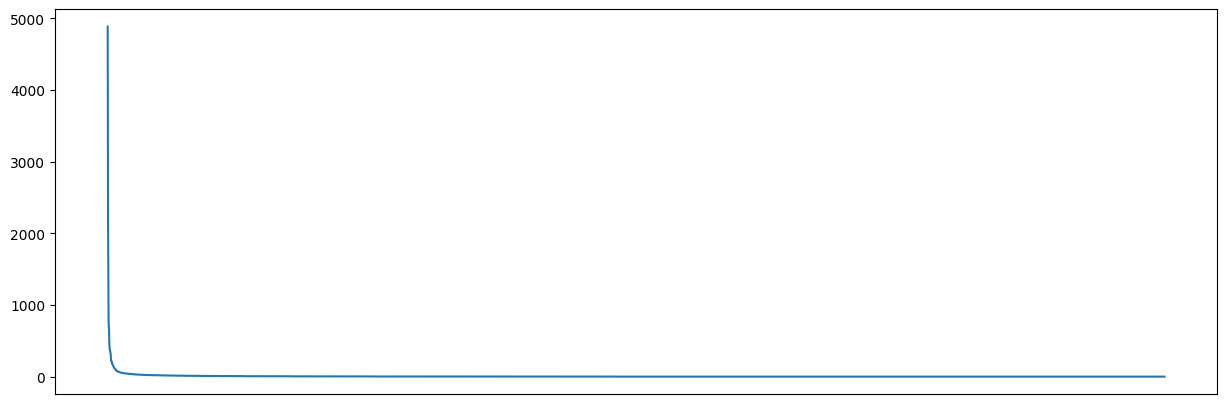

In [91]:
fig=plt.figure(figsize=(15,5))
p = plt.plot(full_dataset["word"].value_counts())
plt.xticks([])
plt.show()

## Data splitting





Creation of train, validation and test sets.

In [92]:
df_train = loadCorpus(1,101) 
df_val = loadCorpus(101,151)
df_test = loadCorpus(151,200)

df_train.count()

word     47356
label    47356
dtype: int64

In [93]:
df_val.count()

word     31183
label    31183
dtype: int64

In [94]:
df_test.count()

word     15545
label    15545
dtype: int64

## Data pre-processing

Clean the data.

In [95]:
def cleanCorpus(corpus):
    corpus['word'] = corpus['word'].str.lower()
    corpus["word"] = [re.sub(r'[^\w]', '', word) for word in corpus["word"]]
    corpus = corpus[corpus["word"] != ""]
    return corpus

In [96]:
#cleaned dataframes
dfc_train = cleanCorpus(df_train)
dfc_val = cleanCorpus(df_val)
dfc_test = cleanCorpus(df_test)

dfc_train.count()

word     41149
label    41149
dtype: int64

In [97]:
dfc_val.count()

word     27263
label    27263
dtype: int64

In [98]:
dfc_test.count()

word     13614
label    13614
dtype: int64

In [99]:
dfc_train.head(10)

,word,label
0,pierre,NNP
1,vinken,NNP
3,61,CD
4,years,NNS
5,old,JJ
7,will,MD
8,join,VB
9,the,DT
10,board,NN
11,as,IN


## Word embedding

Definition of a tokenizer.

In [106]:
from tensorflow.keras.preprocessing.text import Tokenizer
# define the tokenizer
tokenizer = Tokenizer()
text = dfc_train.word.values
#fit the tokenizer on the training data
tokenizer.fit_on_texts(text)
#dictionary containing words as keys and index as values
word_to_index = tokenizer.word_index 

# number of unique words in dict.
print("Number of unique words in dictionary=", 
      len(tokenizer.word_index))
print("Dictionary head: ", dict(list(tokenizer.word_index.items())[0:10]))

Number of unique words in dictionary= 7304
Dictionary head:  {'the': 1, 'of': 2, 'a': 3, 'to': 4, 'in': 5, 'and': 6, 'for': 7, 's': 8, 'that': 9, 'is': 10}


### Embedding with GloVe


*   Loading pre-trained dense word embedding: Glove.
*   Handling OOV words.






In [107]:
import gensim
import gensim.downloader as gloader

def load_embedding_model(model_type: str,
                         embedding_dimension: int = 50) -> gensim.models.keyedvectors.KeyedVectors:
    """
    Loads a pre-trained word embedding model via gensim library.

    :param model_type: name of the word embedding model to load.
    :param embedding_dimension: size of the embedding space to consider

    :return
        - pre-trained word embedding model (gensim KeyedVectors object)
    """
    download_path = ""
    if model_type.strip().lower() == 'word2vec':
        download_path = "word2vec-google-news-300"

    elif model_type.strip().lower() == 'glove':
        download_path = "glove-wiki-gigaword-{}".format(embedding_dimension)
    elif model_type.strip().lower() == 'fasttext':
        download_path = "fasttext-wiki-news-subwords-300"
    else:
        raise AttributeError("Unsupported embedding model type! Available ones: word2vec, glove, fasttext")
        
    try:
        emb_model = gloader.load(download_path)
    except ValueError as e:
        print("Invalid embedding model name! Check the embedding dimension:")
        print("Word2Vec: 300")
        print("Glove: 50, 100, 200, 300")
        print('FastText: 300')
        raise e

    return emb_model

In [108]:
# Modify these variables as you wish!
# Glove -> 50, 100, 200, 300
# Word2Vec -> 300
# Fasttext -> 300
embedding_model = load_embedding_model(model_type="glove",
                                       embedding_dimension=50)

[==================================================] 100.0% 66.0/66.0MB downloaded


Define the embedding matrix.

In [109]:
from tqdm import tqdm

def build_embedding_matrix(embedding_model: gensim.models.keyedvectors.KeyedVectors,
                           embedding_dimension: int,
                           word_to_idx,
                           vocab_size: int) -> np.ndarray:
    """
    Builds the embedding matrix of a specific dataset given a pre-trained word embedding model

    :param embedding_model: pre-trained word embedding model (gensim wrapper)
    :param word_to_idx: vocabulary map (word -> index) (dict)
    :param vocab_size: size of the vocabulary
    

    :return
        - embedding matrix that assigns a high dimensional vector to each word in the dataset specific vocabulary (shape |V| x d)
    """
    embedding_matrix = np.zeros((vocab_size, embedding_dimension), dtype=np.float32)
    for word, idx in tqdm(word_to_idx.items()):
        try:
            embedding_vector = embedding_model[word]
        except (KeyError, TypeError):
            embedding_vector = np.random.uniform(low=-0.05, high=0.05, size=embedding_dimension)

        embedding_matrix[idx] = embedding_vector

    return embedding_matrix

In [110]:
# Testing
embedding_dimension = 50
vocab_size = len(word_to_index) + 1
embedding_matrix = build_embedding_matrix(embedding_model, embedding_dimension, word_to_index, vocab_size )
print(f"Embedding matrix shape: {embedding_matrix.shape}")

100%|██████████| 7304/7304 [00:00<00:00, 345449.99it/s]

Embedding matrix shape: (7305, 50)


Define a label encoder for the target class.

In [111]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
dfc_val['encoded_label'] = le.transform(dfc_val['label'])
dfc_test['encoded_label'] = le.transform(dfc_test['label'])

/tmp/ipykernel_3195/50251909.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_train['encoded_label'] = le.fit_transform(dfc_train['label'])
/tmp/ipykernel_3195/50251909.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfc_val['encoded_label'] = le.transform(dfc_val['label'])
/tmp/ipykernel_3195/50251909.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http

Transform the text into a sequence of integers using the tokenizer defined before. 

In [112]:
x_train = np.array(tokenizer.texts_to_sequences(dfc_train.word.values)) 
y_train =np.array( dfc_train['encoded_label'])

x_val = np.array(tokenizer.texts_to_sequences(dfc_val.word.values))
y_val = np.array(dfc_val['encoded_label'])

x_test = np.array(tokenizer.texts_to_sequences(dfc_test.word.values))
y_test = np.array(dfc_test['encoded_label'])

#number of unique labels
num_classes = len(np.unique(y_train))
vocab_size = len(word_to_index) + 1


/tmp/ipykernel_3195/1004152125.py:4: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_val = np.array(tokenizer.texts_to_sequences(dfc_val.word.values))
/tmp/ipykernel_3195/1004152125.py:7: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  x_test = np.array(tokenizer.texts_to_sequences(dfc_test.word.values))


Pad the sequences to make them of same length before passing them to the model.

In [113]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

x_train = pad_sequences(x_train, maxlen=1, padding='post')
x_val = pad_sequences(x_val, maxlen=1, padding='post')
x_test = pad_sequences(x_test, maxlen=1, padding='post')

#Train
print(f'X train shape: {x_train.shape}')
print(f'Y train shape: {y_train.shape}')
print(f'type:{type(x_train)}')

# Val
print(f'X val shape: {x_val.shape}')
print(f'Y val shape: {y_val.shape}')
print(f'type:{type(y_train)}')
# Test

print(f'X test shape: {x_test.shape}', x_test.shape)
print(f'Y test shape: {y_test.shape}', y_test.shape)

X train shape: (41149, 1)
Y train shape: (41149,)
type:<class 'numpy.ndarray'>
X val shape: (27263, 1)
Y val shape: (27263,)
type:<class 'numpy.ndarray'>
X test shape: (13614, 1) (13614, 1)
Y test shape: (13614,) (13614,)


Define the model.

In [114]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Bidirectional 

model = Sequential()
embedding_layer = Embedding(input_dim = vocab_size,output_dim= embedding_dimension,input_length=1, weights = [embedding_matrix], trainable = False)
model.add(embedding_layer)
model.add(Bidirectional(LSTM(32)))
model.add(Dense(num_classes,activation='softmax'))

model.summary()

2022-12-04 16:51:47.498305: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-04 16:51:47.604915: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-04 16:51:47.605340: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:966] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2022-12-04 16:51:47.608629: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 50)             365250    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               21248     
 l)                                                              
                                                                 
 dense (Dense)               (None, 39)                2535      
                                                                 
Total params: 389,033
Trainable params: 23,783
Non-trainable params: 365,250
_________________________________________________________________


In [115]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [116]:
# fit model
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), batch_size = 64, epochs=30)

Epoch 1/30


2022-12-04 16:51:55.310344: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


643/643 [==============================] - 21s 22ms/step - loss: 1.8515 - accuracy: 0.5223 - val_loss: 1.3407 - val_accuracy: 0.6271
Epoch 2/30
643/643 [==============================] - 12s 18ms/step - loss: 1.0351 - accuracy: 0.7095 - val_loss: 1.0898 - val_accuracy: 0.6744
Epoch 3/30
643/643 [==============================] - 12s 18ms/step - loss: 0.8521 - accuracy: 0.7539 - val_loss: 0.9866 - val_accuracy: 0.7099
Epoch 4/30
643/643 [==============================] - 11s 18ms/step - loss: 0.7534 - accuracy: 0.7823 - val_loss: 0.9293 - val_accuracy: 0.7296
Epoch 5/30
643/643 [==============================] - 11s 17ms/step - loss: 0.6883 - accuracy: 0.7975 - val_loss: 0.8895 - val_accuracy: 0.7380
Epoch 6/30
643/643 [==============================] - 12s 18ms/step - loss: 0.6403 - accuracy: 0.8100 - val_loss: 0.8653 - val_accuracy: 0.7380
Epoch 7/30
643/643 [==============================] - 13s 20ms/step - loss: 0.6029 - accuracy: 0.8212 - val_loss: 0.8482 - val_accuracy: 0.7408
Epo

In [117]:
model.evaluate(x_test, y_test)

426/426 [==============================] - 4s 10ms/step - loss: 0.6431 - accuracy: 0.7885


[0.643083393573761, 0.7885265350341797]

## Baseline model: LSTM

## Model A: LSTM + GRU

## Model B: 2x LSTM 

## Model C: LSTM + Dense

## Conclusions